In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

## 局部平移扭曲（Local Transition warps）

算法原理来自于论文《Interactive Image Warping》

一般应用于瘦脸效果。

公式：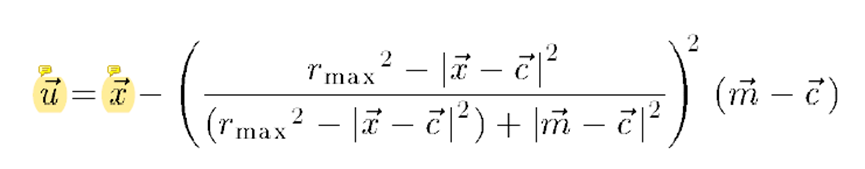

说明：坐标矢量u(->)表示结果坐标，坐标矢量x(->)表示目标坐标，其中c(->)是中心位置，m(->)是当前鼠标光标位置（可以理解变形强度），rmax是影响区域的半径（需要变形的区域）。通过这个函数求目标坐标x(->)的对应逆映射的结果坐标u(->)，目标坐标x(->)的像素值大小是通过结果坐标u(->)在原图上运用双线性插值求出的。

代码如下：

In [19]:
def local_translation_warp(srcImg, center, end_point, radius):
    """
    局部平移扭曲算法（Local Transition warps）
    :param srcImg:需要处理的数字图像
    :param center:变形区域的中心点坐标
    :param end_point:形变终点，代表形变的方向和强度，对应公式中的m
    :param radius: 变形范围的半径
    :return: copyImg，变换后的像素值
    """
    startX, startY = center[0], center[1]
    endX, endY = end_point[0], end_point[1]
    ddradius = float(radius * radius)
    copyImg = srcImg.copy()
    # 计算公式中的|m-c|^2
    ddmc = (endX - startX) * (endX - startX) + (endY - startY) * (endY - startY)
    H, W, _ = srcImg.shape
    for i in range(W):
        for j in range(H):
            # 选取变形区域内的数据进行处理
            if math.fabs(i - startX) > radius and math.fabs(j - startY) > radius:
                continue
            distance = (i - startX) * (i - startX) + (j - startY) * (j - startY)
            if distance < ddradius:
                # 计算出（i,j）坐标的原坐标
                ratio = (ddradius - distance) / (ddradius - distance + ddmc)
                ratio = ratio * ratio
                # 逆映射原位置
                UX = i - ratio * (endX - startX)
                UY = j - ratio * (endY - startY)
                # 根据双线性插值法得到UX，UY的值
                value = bilinear_insert(srcImg, UX, UY)
                # 改变像素值
                copyImg[j, i] = value
    return copyImg

## 局部缩放扭曲（Local scaling warps）

算法原理来自于论文《Interactive Image Warping》

一般应用于大眼效果。

公式：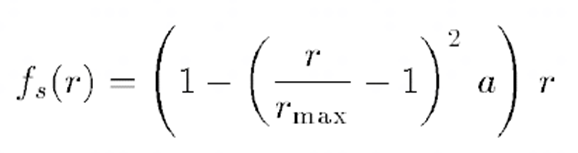

说明：rmax为眼部圆形变形区域的半径，r代表当前坐标离圆心的距离，a变形强度参数，fs(r)为变形后的点到圆心的距离。

In [11]:
def local_scaling_wraps(src_img, center, radius, k0):
    """
    局部缩放算法（Local scaling warps）
    :param src_img:输入原图
    :param center:变形中心点
    :param radius:变形区域的半径
    :param k0:形变参数
    :return:copy_img，变换后的像素值
    """
    start_x = center[0]
    start_y = center[1]
    ddradius = float(radius * radius)
    copy_img = src_img.copy()
    H, W, _ = src_img.shape
    for i in range(W):
        for j in range(H):
            # 选取变形区域内的像素点进行处理
            if math.fabs(i - start_x) > radius and math.fabs(j - start_y) > radius:
                continue
            distance = (i - start_x) * (i - start_x) + \
                       (j - start_y) * (j - start_y)
            if distance < ddradius:
                # 计算公式中右边平方号里的部分
                rnorm = math.sqrt(distance) / radius
                # k0<0时，为缩小；k0>0时，为放大。放大一般可取0.5
                ratio = 1 - (rnorm - 1) * (rnorm - 1) * k0
                # 映射到像素原位置
                # TODO:按照原论文这里的计算是有偏差的，这里没有考虑角度
                ux = start_x + ratio * (i - start_x)
                uy = start_y + ratio * (j - start_y)
                # 这里直接取附近像素点的值，没用线性插值
                value = src_img[int(uy), int(ux)]
                # 改变像素值
                copy_img[j, i] = value
    return copy_img


## 双线性插值

In [5]:
def bilinear_insert(src, ux, uy):
    """
    双线性插值法
    :param src: 原坐标值
    :param ux: 目标x轴坐标
    :param uy: 目标x轴坐标
    :return: insert_value，插值后的值
    """
    _, _, c = src.shape
    if c == 3:  # rgb三个值
        # 插值运算
        x1 = int(ux)
        x2 = x1 + 1
        y1 = int(uy)
        y2 = y1 + 1
        part1 = src[y1, x1].astype(float) * (float(x2) - ux) * (float(y2) - uy)
        part2 = src[y1, x2].astype(float) * (ux - float(x1)) * (float(y2) - uy)
        part3 = src[y2, x1].astype(float) * (float(x2) - ux) * (uy - float(y1))
        part4 = src[y2, x2].astype(float) * (ux - float(x1)) * (uy - float(y1))
        insert_value = part1 + part2 + part3 + part4
        insert_value = insert_value.astype(np.int8)

    return insert_value

## 效果展示

(500, 476, 3)


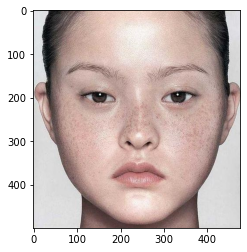

In [6]:
# 原图
src = cv2.imread('E:/python-dlib-project/2.jpg')
print(src.shape)
src1 = src[:, :, ::-1] 	# transform image to rgb
plt.imshow(src1)
plt.show()

### 大眼算法

变形说明图片：
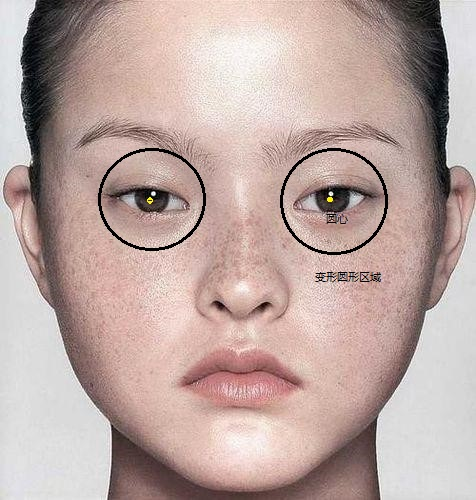

In [12]:
def big_eye(img):
    """
    大眼算法实例
    """
    c1 = [150, 200]  # 左眼变形圆形区域的圆心坐标
    c2 = [330, 200]  # 右眼变形圆形区域的圆心坐标
    r = 50  # 变形圆形区域的半径
    a = 0.5  # 变形参数
    # 左眼
    out_img1 = local_scaling_wraps(img, c1, r, a)
    # 右眼
    out_img = local_scaling_wraps(out_img1, c2, r, a)
    names = 'E:/python-dlib-project/result_img/big_eyes_20220617.png'
    return out_img, names

E:/python-dlib-project/result_img/big_eyes_20220617.png


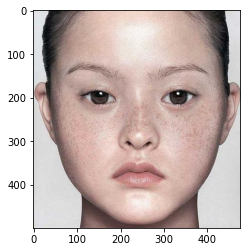

In [13]:
# 效果展示
new_img, name = big_eye(src)
print(name)
cv2.imwrite(name, new_img)
new_img1 = new_img[:, :, ::-1] 	# transform image to rgb
plt.imshow(new_img1)
plt.show()

### 瘦脸算法

变形说明图片：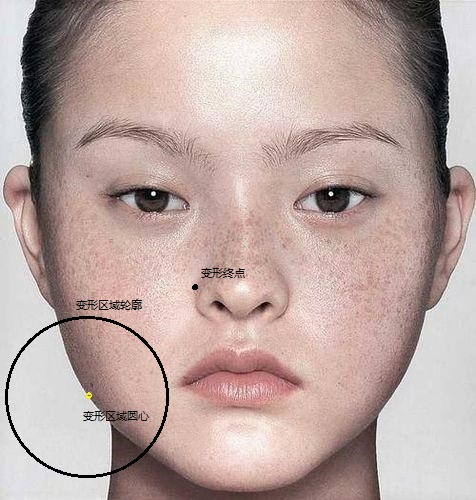


In [28]:
def thin_face(img):
    """
    瘦脸算法实例
    """
    c = [90, 400]  # 变形区域的圆心
    m = [195, 290]  # 变形终点，变形的程度和方向
    c1 = [390, 400]
    m1 = [280, 280]
    radius_ = 80
    # 瘦左边脸
    out_img1 = local_translation_warp(img, c, m, radius_)
    # 瘦右边脸
    out_img = local_translation_warp(out_img1, c1, m1, radius_)
    # 图片存储路径
    names = 'E:/python-dlib-project/result_img/thin_face_20220616.png'
    return out_img, names

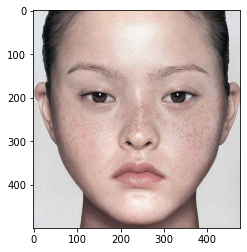

In [29]:
# 效果展示
new_img_thin, name1 = thin_face(src)
# 变换后保存本地
cv2.imwrite(name1, new_img_thin)
new_img_thin1 = new_img_thin[:, :, ::-1] 	# transform image to rgb
plt.imshow(new_img_thin1)
plt.show()